In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import scorpyo as sp

from null_importance import get_null_importance


pd.set_option('max_rows', 500, 'max_columns', 200)

In [2]:
path_project = r'/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification'

# path dir
path_row_data = os.path.join(path_project, 'row_data')
path_new_data = os.path.join(path_project, 'new_data')
path_results  = os.path.join(path_project, 'results')
path_results_jupyter  = os.path.join(path_results, 'jupyter')

# path row_data
path_train = os.path.join(path_row_data, 'train.csv')
path_test  = os.path.join(path_row_data, 'evaluation_public.csv')
path_sample_submission = os.path.join(path_row_data, 'submit_example.csv')


path_new_train = os.path.join(path_new_data, 'train_lightgbm_20221014.csv')
path_new_test  = os.path.join(path_new_data, 'test_lightgbm_20221014.csv')

## results
path_output_report = os.path.join(path_results, '01_原始数据探察_20221014.xlsx')

y_label = "is_risk"

In [3]:
df_row_train = sp.read_data(path_train)
df_row_val  = sp.read_data(path_test)

df_row_train['url_sit'] = df_row_train['url'].map(lambda x: x.split('/')[0])
df_row_train['url_page'] = df_row_train['url'].map(lambda x: x.split('/')[1])

df_row_val['url_sit'] = df_row_val['url'].map(lambda x: x.split('/')[0])
df_row_val['url_page'] = df_row_val['url'].map(lambda x: x.split('/')[1])



df_train_info = df_row_train.copy().sort_values(by='op_datetime')

## 定义一次/一天/一月
1. op\_times\_groups 一次
2. op\_days 一天
3. op\_month 一月

In [4]:
df = pd.concat([df_row_train, df_row_val]).reset_index(drop=True)
df = df.sort_values(by='op_datetime')

# 认证日期时间
df['op_datetime'] = pd.to_datetime(df['op_datetime'])
# 将数据分为每一天
df['op_days'] = df['op_datetime'].map(lambda x: x.strftime('%Y-%m-%d'))

# 按客户进行统计这次认证和上次认证的时间差
df['op_second'] = df['op_datetime']
df['op_second1'] = df.groupby('device_num_transform')['op_second'].shift(1)
df['op_diff_second1'] = (df['op_second'] - df['op_second1']).map(lambda x: x.total_seconds())
df['op_diff_second1_tmp'] = df['op_diff_second1']>10
# 客户第几次登录
df['op_times_groups'] = df.groupby('device_num_transform')['op_diff_second1_tmp'].apply(lambda x: x.cumsum())

# 系统层面的一段时间
df['system_op_second'] = df['op_datetime']
df['system_op_second1'] = df['system_op_second'].shift(1)
df['system_op_diff_second1'] = (df['system_op_second'] - df['system_op_second1']).map(lambda x: x.total_seconds())
df['system_op_diff_second1_tmp'] = df['system_op_diff_second1']>400
# 客户第几次登录
df['system_op_times_groups'] = df['system_op_diff_second1_tmp'].cumsum()

df = df.drop(columns=['op_second','op_second1','op_diff_second1_tmp', 
                      'system_op_second', 'system_op_second1', 'system_op_diff_second1_tmp'])

## 环境特征

In [5]:

time_feats = ['system_op_times_groups', 'op_days', 'op_month']

cate_feats = ['ip_transform', 'user_name', 'device_num_transform', 'department', 'browser_version', 'browser', 'os_type','os_version',
              'ip_type','http_status_code', 'op_city', 'log_system_transform', 'url', 'url_page','url_sit']

# 客户+时间+按时间cumsum/cumunique
# 累计量统计
df['helper'] = 1
# 是否为异常状态码
df['http_status_code_helper'] = df['http_status_code'].map(lambda x: 1 if x in [400, 500, 502, 404] else 0) 
# 给样本编号
df['sampler_index_helper'] = df['helper'].cumsum()

for i in time_feats:
    i_tmp = df.groupby([i])
    # 系统往前看，处理了多少事
    df['system_{}_cumsum'.format(i)] = i_tmp['helper'].cumsum()
    # 系统往前看，处理了多少坏事
    df['system_{}_error_code_cumsum'.format(i)] = i_tmp['http_status_code_helper'].cumsum()
    for j in cate_feats:
        index_set = set(df.groupby([i, j],as_index=False).first()['sampler_index_helper'].values)
        df['tmp_helper'] = df['sampler_index_helper'].map(lambda x: 1 if x in index_set else 0)
        # 系统往前看，不同维度的处理了多少情况
        df['system_{}_{}_cumunique'.format(i, j)] = df.groupby([i, j])['tmp_helper'].cumsum()
        
        if j not in ['ip_transform', 'user_name', 'device_num_transform']:
            for k in df[j].unique():
                tmp = df[df[j]==k].groupby([i])

                # 系统往前看，不同维度不同情况分别处理了多少次
                df['system_{}_{}_{}_cumsum'.format(i,j,k)] = tmp['helper'].cumsum()
                # 系统往前看，不同维度不同情况error_code分别处理了多少次
                df['system_{}_{}_{}_error_code_cumsum'.format(i,j,k)] = tmp['http_status_code_helper'].cumsum()

remove_cols = [x for x in df.columns if x[-6:]=='helper']

df = df.drop(columns=remove_cols)

## 对象层面

In [6]:

time_feats = ['op_times_groups', 'op_days', 'op_month']

object_feats = ['ip_transform', 'user_name', 'device_num_transform']

cate_feats = ['ip_transform', 'user_name', 'device_num_transform', 'department', 'browser_version', 'browser', 'os_type','os_version',
              'ip_type','http_status_code', 'op_city', 'log_system_transform', 'url', 'url_page','url_sit']

# 客户+时间+按时间cumsum/cumunique
# 累计量统计
df['helper'] = 1
# 是否为异常状态码
df['http_status_code_helper'] = df['http_status_code'].map(lambda x: 1 if x in [400, 500, 502, 404] else 0) 
# 给样本编号
df['sampler_index_helper'] = df['helper'].cumsum()


for i in time_feats:
    for j in object_feats:
        j_tmp = df.groupby([i,j])
        df['{}_{}_cumsum'.format(i,j)] = j_tmp['helper'].cumsum()
        df['{}_{}_error_code_cumsum'.format(i,j)] = j_tmp['http_status_code_helper'].cumsum()
        for k in cate_feats:
            if k == j: continue
            index_set = set(df.groupby([i,j,k], as_index=False).first()['sampler_index_helper'].values)            
            df['tmp_helper'] = df['sampler_index_helper'].map(lambda x: 1 if x in index_set else 0)
            df['{}_{}_{}_cumunique'.format(i,j,k)] = df.groupby([i,j,k])['tmp_helper'].cumsum()
            
            if k not in ['ip_transform', 'user_name', 'device_num_transform']:
                for v in df[k].unique():
                    v_tmp = df[df[k]==v].groupby([i,j])
                    df['{}_{}_{}_{}_cumsum'.format(i,j,k,v)] = v_tmp['helper'].cumsum()
                    df['{}_{}_{}_{}_error_code_cumsum'.format(i,j,k,v)] = v_tmp['http_status_code_helper'].cumsum()

remove_cols = [x for x in df.columns if x[-6:]=='helper']

df = df.drop(columns=remove_cols)

## 其它操作

In [7]:
# 几点钟
df['hour'] = df['op_datetime'].dt.hour
df['hour_sin'] = np.sin(df['hour']/24*2*np.pi)
df['hour_cos'] = np.cos(df['hour']/24*2*np.pi)

# 周几
df['dayofweek'] = df['op_datetime'].dt.dayofweek
df['dayofweek_sin'] = np.sin(df['dayofweek']/7*2*np.pi)
df['dayofweek_cos'] = np.cos(df['dayofweek']/7*2*np.pi)

# 一个月的第几天
df['day'] = df['op_datetime'].dt.day
df['day_sin'] = np.sin(df['day']/31*2*np.pi)
df['day_cos'] = np.cos(df['day']/31*2*np.pi)

## 特征筛选

In [8]:
# 删除时间及类别型变量过多的特征
remove_col = ['op_datetime', 'op_month', 'user_name', 'ip_transform', 'device_num_transform', 'op_days', 'ts', 'ts1', 'ts2','ts3']

remove_col = [x for x in df.columns if x in remove_col]
df = df.drop(columns=remove_col)
df.head()

,id,department,browser_version,browser,os_type,os_version,ip_type,http_status_code,op_city,log_system_transform,url,is_risk,url_sit,url_page,op_diff_second1,op_times_groups,system_op_diff_second1,system_op_times_groups,system_system_op_times_groups_cumsum,system_system_op_times_groups_error_code_cumsum,system_system_op_times_groups_ip_transform_cumunique,system_system_op_times_groups_user_name_cumunique,system_system_op_times_groups_device_num_transform_cumunique,system_system_op_times_groups_department_cumunique,system_system_op_times_groups_department_rd_cumsum,system_system_op_times_groups_department_rd_error_code_cumsum,system_system_op_times_groups_department_hr_cumsum,system_system_op_times_groups_department_hr_error_code_cumsum,system_system_op_times_groups_department_sales_cumsum,system_system_op_times_groups_department_sales_error_code_cumsum,system_system_op_times_groups_department_other_cumsum,system_system_op_times_groups_department_other_error_code_cumsum,system_system_op_times_groups_department_nan_cumsum,system_system_op_times_groups_department_nan_error_code_cumsum,system_system_op_times_groups_department_accounting_cumsum,system_system_op_times_groups_department_accounting_error_code_cumsum,system_system_op_times_groups_browser_version_cumunique,system_system_op_times_groups_browser_version_chrome_93_cumsum,system_system_op_times_groups_browser_version_chrome_93_error_code_cumsum,system_system_op_times_groups_browser_version_safari_13_cumsum,system_system_op_times_groups_browser_version_safari_13_error_code_cumsum,system_system_op_times_groups_browser_version_firefox_78_cumsum,system_system_op_times_groups_browser_version_firefox_78_error_code_cumsum,system_system_op_times_groups_browser_version_edge_93_cumsum,system_system_op_times_groups_browser_version_edge_93_error_code_cumsum,system_system_op_times_groups_browser_version_ie_9_cumsum,system_system_op_times_groups_browser_version_ie_9_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_77_cumsum,system_system_op_times_groups_browser_version_chrome_77_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_90_cumsum,system_system_op_times_groups_browser_version_chrome_90_error_code_cumsum,system_system_op_times_groups_browser_version_ie_11_cumsum,system_system_op_times_groups_browser_version_ie_11_error_code_cumsum,system_system_op_times_groups_browser_cumunique,system_system_op_times_groups_browser_chrome_cumsum,system_system_op_times_groups_browser_chrome_error_code_cumsum,system_system_op_times_groups_browser_safari_cumsum,system_system_op_times_groups_browser_safari_error_code_cumsum,system_system_op_times_groups_browser_firefox_cumsum,system_system_op_times_groups_browser_firefox_error_code_cumsum,system_system_op_times_groups_browser_edge_cumsum,system_system_op_times_groups_browser_edge_error_code_cumsum,system_system_op_times_groups_browser_ie_cumsum,system_system_op_times_groups_browser_ie_error_code_cumsum,system_system_op_times_groups_os_type_cumunique,system_system_op_times_groups_os_type_win_cumsum,system_system_op_times_groups_os_type_win_error_code_cumsum,system_system_op_times_groups_os_type_macos_cumsum,system_system_op_times_groups_os_type_macos_error_code_cumsum,system_system_op_times_groups_os_version_cumunique,system_system_op_times_groups_os_version_win10_cumsum,system_system_op_times_groups_os_version_win10_error_code_cumsum,system_system_op_times_groups_os_version_macos_big_sur_11_cumsum,system_system_op_times_groups_os_version_macos_big_sur_11_error_code_cumsum,system_system_op_times_groups_os_version_win7_cumsum,system_system_op_times_groups_os_version_win7_error_code_cumsum,system_system_op_times_groups_os_version_win11_cumsum,system_system_op_times_groups_os_version_win11_error_code_cumsum,system_system_op_times_groups_ip_type_cumunique,system_system_op_times_groups_ip_type_内网_cumsum,system_system_op_times_groups_ip_type_内网_error_code_cumsum,system_system_op_times_groups_ip_type_nan_cumsum,system_

### 评分卡特征筛选

In [9]:
df_row_train = df[df[y_label].notna()].reset_index(drop=True)
df_row_val = df[df[y_label].isna()].reset_index(drop=True)

df_train, df_test, convert_cols = sp.transform_data_detail(df_row_train, df_row_val, y_label, excel_path=path_output_report)
df_train.head()

sheet05.可能为数值类型的object类型数据统计在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖
sheet06.数据预处理在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


,id,department,browser_version,browser,os_version,op_city,log_system_transform,url,is_risk,url_sit,url_page,op_diff_second1,op_times_groups,system_op_diff_second1,system_op_times_groups,system_system_op_times_groups_cumsum,system_system_op_times_groups_error_code_cumsum,system_system_op_times_groups_department_rd_cumsum,system_system_op_times_groups_department_rd_error_code_cumsum,system_system_op_times_groups_department_sales_cumsum,system_system_op_times_groups_department_sales_error_code_cumsum,system_system_op_times_groups_browser_version_edge_93_cumsum,system_system_op_times_groups_browser_version_edge_93_error_code_cumsum,system_system_op_times_groups_browser_version_chrome_90_cumsum,system_system_op_times_groups_browser_version_chrome_90_error_code_cumsum,system_system_op_times_groups_browser_chrome_cumsum,system_system_op_times_groups_browser_chrome_error_code_cumsum,system_system_op_times_groups_browser_edge_cumsum,system_system_op_times_groups_browser_edge_error_code_cumsum,system_system_op_times_groups_os_type_win_cumsum,system_system_op_times_groups_os_type_win_error_code_cumsum,system_system_op_times_groups_os_version_win10_cumsum,system_system_op_times_groups_os_version_win10_error_code_cumsum,system_system_op_times_groups_os_version_win7_cumsum,system_system_op_times_groups_os_version_win7_error_code_cumsum,system_system_op_times_groups_ip_type_内网_cumsum,system_system_op_times_groups_ip_type_内网_error_code_cumsum,system_system_op_times_groups_http_status_code_200_cumsum,system_system_op_times_groups_op_city_深圳_cumsum,system_system_op_times_groups_op_city_深圳_error_code_cumsum,system_system_op_times_groups_op_city_成都_cumsum,system_system_op_times_groups_op_city_成都_error_code_cumsum,system_system_op_times_groups_op_city_杭州_cumsum,system_system_op_times_groups_op_city_杭州_error_code_cumsum,system_system_op_times_groups_op_city_北京_cumsum,system_system_op_times_groups_op_city_北京_error_code_cumsum,system_system_op_times_groups_log_system_transform_nHrKgKdJ1Mzt_cumsum,system_system_op_times_groups_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum,system_system_op_times_groups_log_system_transform_dwS3cdn15GK4_cumsum,system_system_op_times_groups_log_system_transform_dwS3cdn15GK4_error_code_cumsum,system_system_op_times_groups_url_xxx.com/github_cumsum,system_system_op_times_groups_url_xxx.com/github_error_code_cumsum,system_system_op_times_groups_url_wpsdoc.xxx.com/download_cumsum,system_system_op_times_groups_url_wpsdoc.xxx.com/download_error_code_cumsum,system_system_op_times_groups_url_page_github_cumsum,system_system_op_times_groups_url_page_github_error_code_cumsum,system_system_op_times_groups_url_page_download_cumsum,system_system_op_times_groups_url_page_download_error_code_cumsum,system_system_op_times_groups_url_sit_xxx.com_cumsum,system_system_op_times_groups_url_sit_xxx.com_error_code_cumsum,system_system_op_times_groups_url_sit_wpsdoc.xxx.com_cumsum,system_system_op_times_groups_url_sit_wpsdoc.xxx.com_error_code_cumsum,system_op_days_cumsum,system_op_days_error_code_cumsum,system_op_days_department_rd_cumsum,system_op_days_department_rd_error_code_cumsum,system_op_days_department_sales_cumsum,system_op_days_department_sales_error_code_cumsum,system_op_days_browser_version_edge_93_cumsum,system_op_days_browser_version_edge_93_error_code_cumsum,system_op_days_browser_version_chrome_90_cumsum,system_op_days_browser_version_chrome_90_error_code_cumsum,system_op_days_browser_chrome_cumsum,system_op_days_browser_chrome_error_code_cumsum,system_op_days_browser_edge_cumsum,system_op_days_browser_edge_error_code_cumsum,system_op_days_os_type_win_cumsum,system_op_days_os_type_win_error_code_cumsum,system_op_days_os_version_win10_cumsum,system_op_days_os_version_win10_error_code_cumsum,system_op_days_os_version_win7_cumsum,system_op_days_os_version_win7_error_code_cumsum,system_op_days_ip_type_内网_cumsum,system_op_days_ip_type_内网_error_code_cumsum,system_op_days_http_status_code_200_cumsum,system_op_days_op_city_深圳_cum

In [10]:
train_woe, val_woe, bins_adj = sp.binning_data_detail(train=df_train,
                        test=df_test, y=y_label, excel_path=path_output_report, var_skip=['id'],)

There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)
There are 160 variables have only one binning intervals，please check the binning result. 
 (ColumnNames: op_times_groups_user_name_url_sit_wpsdoc.xxx.com_error_code_cumsum, op_days_device_num_transform_browser_edge_error_code_cumsum, op_times_groups_device_num_transform_op_city_杭州_cumsum, op_times_groups_user_name_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum, op_times_groups_user_name_url_xxx.com/github_cumsum, op_times_groups_user_name_department_sales_error_code_cumsum, op_times_groups_user_name_op_city_北京_cumsum, op_times_groups_device_num_transform_browser_version_chrome_90_error_code_cumsum, op_month_ip_transform_os_version_win7_error_code_cumsum, op_times_groups_user_name_log_system_transform_dwS3cdn15GK4_error_code_cumsum, system_op_days_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum, op_days_device_num_transform_url_xxx.com/github_error_code_cumsum, op_times_groups_device_nu

sheet07.初始分箱结果在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖
特征op_times_groups_user_name_url_sit_wpsdoc.xxx.com_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_days_device_num_transform_browser_edge_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_device_num_transform_op_city_杭州_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_name_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_name_url_xxx.com/github_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_name_department_sales_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_name_op_city_北京_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_device_num_transform_browser_version_chrome_90_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_month_ip_transform_os_version_win7_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_nam

特征op_times_groups_device_num_transform_ip_type_内网_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_days_user_name_browser_version_chrome_90_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_device_num_transform_browser_chrome_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_user_name_op_city_北京_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_month_device_num_transform_url_xxx.com/github_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_month_ip_transform_url_xxx.com/github_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_ip_transform_url_xxx.com/github_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_days_user_name_log_system_transform_nHrKgKdJ1Mzt_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_days_ip_transform_op_city_北京_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_days_user_name_os_version_win10_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无法调整, 建议删除
特征op_times_groups_device_num_transform_url_page_download_error_code_cumsum，除特殊值分箱外，分箱箱数少于2箱，无

[INFO] converting into woe values ...


There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)


Woe transformating on 47660 rows and 419 columns in 00:00:36
[INFO] converting into woe values ...


There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: url_page)


Woe transformating on 25710 rows and 419 columns in 00:00:19


sheet09.调整后分箱结果在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


In [11]:
res_data, res_val, bins_selection = sp.select_feat_detail(train_woe, val_woe,df_test, y_label, bins_adj,exclude=['id'],
                                                iv_max_threshold=1.5,
                                                remove_negitive_coef=True,
                                                corr_threshold=0.7,
                                                #chi_threshold=0.00001,
                                                excel_path=path_output_report)

变量dayofweek_sin 的分箱结果未通过卡方检验
变量dayofweek 的分箱结果未通过卡方检验
变量op_city 的分箱结果未通过卡方检验
变量op_month_device_num_transform_http_status_code_200_cumsum 的分箱结果未通过卡方检验
变量op_month_ip_transform_op_city_成都_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_page_download_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_page_download_error_code_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_wpsdoc.xxx.com/download_cumsum 的分箱结果未通过卡方检验
变量system_op_month_url_wpsdoc.xxx.com/download_error_code_cumsum 的分箱结果未通过卡方检验
变量system_system_op_times_groups_department_rd_error_code_cumsum 的分箱结果未通过卡方检验
变量url_sit 的分箱结果未通过卡方检验


变量system_op_diff_second1_woe被加入
变量op_month_user_name_http_status_code_200_cumsum_woe被加入
变量op_month_ip_transform_cumsum_woe被加入
变量op_times_groups_device_num_transform_url_page_download_cumsum_woe被加入
变量hour_cos_woe被加入
变量system_op_days_ip_type_内网_cumsum_woe被加入
变量op_month_device_num_transform_cumsum_woe被加入
变量system_system_op_times_groups_ip_type_内网_cumsum_woe被加入
变量op_month_ip_transform_url_sit_xxx.com_cumsum_woe被加入
变量url_woe被加入
变量hour_woe被加入
变量system_op_days_ip_type_内网_error_code_cumsum_woe被加入
变量system_system_op_times_groups_url_sit_xxx.com_cumsum_woe被加入
变量op_times_groups_user_name_cumsum_woe被加入
变量op_month_ip_transform_ip_type_内网_cumsum_woe被加入
变量op_diff_second1_woe被加入
变量system_system_op_times_groups_url_sit_xxx.com_error_code_cumsum_woe被加入
变量system_system_op_times_groups_department_sales_cumsum_woe被加入
变量system_op_days_op_city_深圳_cumsum_woe被加入
变量system_op_days_os_version_win10_error_code_cumsum_woe被加入
变量op_month_user_name_url_sit_xxx.com_error_code_cumsum_woe被加入
变量system_op_days_op_city_成都_c

逐步回归结果


,指标1,取值1,指标2,取值2
0,Dep. Variable:,is_risk,No. Observations:,47660.0000
1,Model:,LogisticRegression,Df Residuals:,47626.0000
2,Method:,MLE,Df Model:,33.0000
3,Date:,Thu; 20 Oct 2022,Pseudo R-squ.:,0.5793
4,Time:,20:51:07,Log-Likelihood:,-8863.6000
5,converged:,True,LL-Null:,-21071.0000
6,Covariance Type:,nonrobust,LLR p-value:,0.0000


,feat,coef,std err,z,P>|z|,[0.025,0.975]
0,intercept ...,-1.8679,0.023,-81.692,0.000,-1.913,-1.823
1,hour_cos_woe ...,0.8720,0.031,28.461,0.000,0.812,0.932
2,op_days_device_num_transform_op_city_成都_cumsum...,0.1894,0.102,1.861,0.063,-0.010,0.389
3,op_days_ip_transform_browser_edge_cumsum_woe ...,0.2753,0.072,3.833,0.000,0.135,0.416
4,op_days_ip_transform_url_sit_xxx.com_cumsum_wo...,0.1599,0.040,3.969,0.000,0.081,0.239
5,op_days_user_name_cumsum_woe ...,1.2639,0.144,8.806,0.000,0.983,1.545
6,op_month_device_num_transform_browser_version_...,0.3192,0.137,2.327,0.020,0.050,0.588
7,op_month_device_num_transform_browser_version_...,0.3378,0.130,2.593,0.010,0.082,0.593
8,op_month_device_num_transform_op_city_北京_error...,0.1979,0.138,1.429,0.153,-0.074,0.469
9,op_month_ip_transform_browser_chrome_cumsum_wo...,0.1233,0.063,1.950,0.051,-0.001,0.247


sheet10.特征筛选在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖
sheet11.特征表现在/Users/liliangshan/workspace/python/01_datasets/ccf_system_access_risk_identification/results/01_原始数据探察_20221014.xlsx中已经存在，我们将对原文件进行覆盖


In [12]:
model = sp.get_lr_model(res_data.drop(columns='id'), y_label)

,指标1,取值1,指标2,取值2
0,Dep. Variable:,is_risk,No. Observations:,47660.0000
1,Model:,LogisticRegression,Df Residuals:,47626.0000
2,Method:,MLE,Df Model:,33.0000
3,Date:,Thu; 20 Oct 2022,Pseudo R-squ.:,0.5793
4,Time:,20:51:16,Log-Likelihood:,-8863.5000
5,converged:,True,LL-Null:,-21071.0000
6,Covariance Type:,nonrobust,LLR p-value:,0.0000


,feat,coef,std err,z,P>|z|,[0.025,0.975]
0,intercept ...,-1.8684,0.023,-81.672,0.000,-1.913,-1.824
1,hour_cos_woe ...,0.8723,0.031,28.468,0.000,0.812,0.932
2,op_days_device_num_transform_op_city_成都_cumsum...,0.1884,0.102,1.850,0.064,-0.011,0.388
3,op_days_ip_transform_browser_edge_cumsum_woe ...,0.2783,0.072,3.871,0.000,0.137,0.419
4,op_days_ip_transform_url_sit_xxx.com_cumsum_wo...,0.1608,0.040,3.989,0.000,0.082,0.240
5,op_days_user_name_cumsum_woe ...,1.2873,0.144,8.965,0.000,1.006,1.569
6,op_month_device_num_transform_browser_version_...,0.3199,0.137,2.331,0.020,0.051,0.589
7,op_month_device_num_transform_browser_version_...,0.3388,0.130,2.600,0.009,0.083,0.594
8,op_month_device_num_transform_op_city_北京_error...,0.2012,0.139,1.452,0.147,-0.070,0.473
9,op_month_ip_transform_browser_chrome_cumsum_wo...,0.1241,0.063,1.963,0.050,0.000,0.248


In [13]:
res_sc = res_data[[y_label]]

res_sc['score'] = model.predict_proba(res_data[res_data.columns.drop([y_label,'id'])])[:,1]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


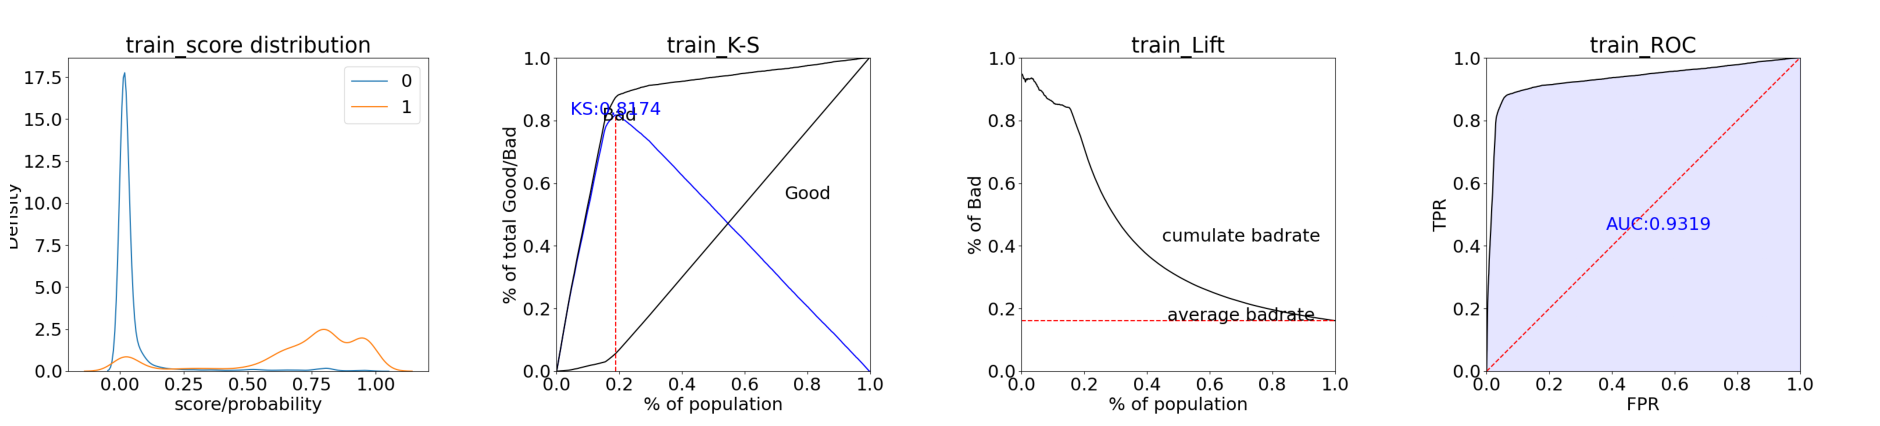

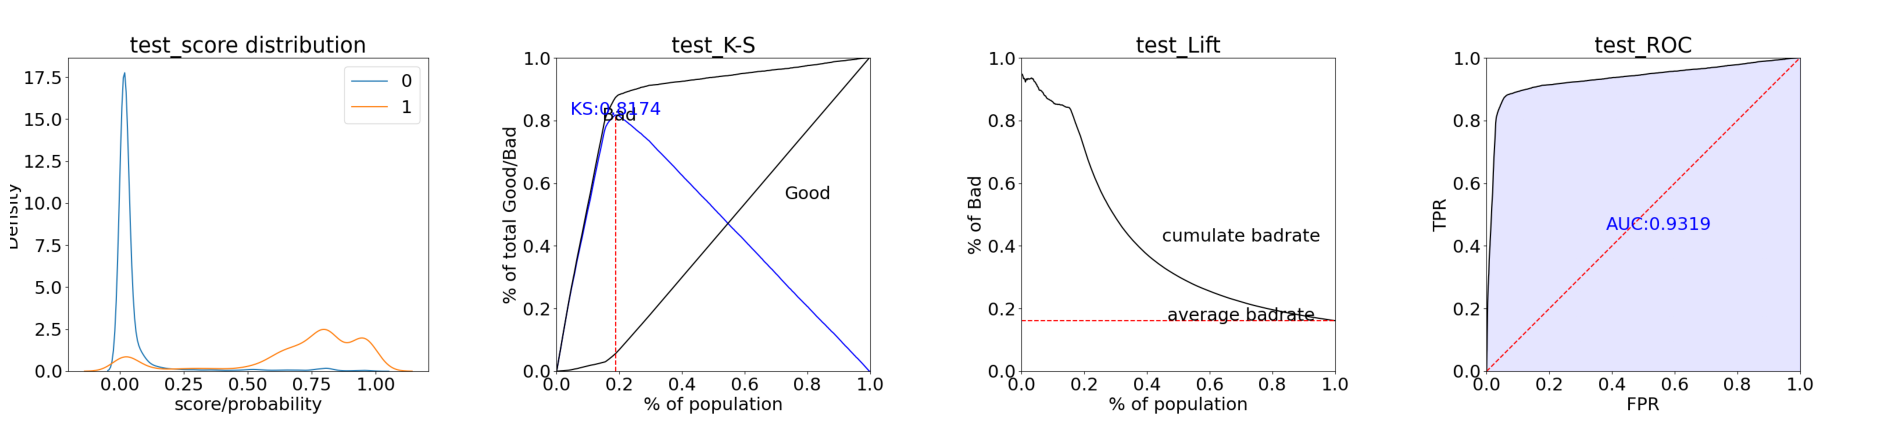

Sample      KS     AUC    GINI      F1  ACCURACY PRECISION  \
阈值是0.0118时的模型表现 0  train  0.8174  0.9319  0.8637  0.3005  25.6232%  17.7137%   
                1   test  0.8174  0.9319  0.8637  0.3005  25.6232%  17.7137%   
阈值是0.014时的模型表现  0  train  0.8174  0.9319  0.8637  0.3283  35.6190%  19.7415%   
                1   test  0.8174  0.9319  0.8637  0.3283  35.6190%  19.7415%   
阈值是0.016时的模型表现  0  train  0.8174  0.9319  0.8637  0.3601  44.7545%  22.1448%   
                1   test  0.8174  0.9319  0.8637  0.3601  44.7545%  22.1448%   
阈值是0.0182时的模型表现 0  train  0.8174  0.9319  0.8637  0.4035  54.6202%  25.6127%   
                1   test  0.8174  0.9319  0.8637  0.4035  54.6202%  25.6127%   
阈值是0.021时的模型表现  0  train  0.8174  0.9319  0.8637  0.4576  64.0978%  30.2645%   
                1   test  0.8174  0.9319  0.8637  0.4576  64.0978%  30.2645%   
阈值是0.026时的模型表现  0  train  0.8174  0.9319  0.8637  0.5317  73.6970%  37.3139%   
                1   test  0.8174  0.9319  0.8637  0.5317  73.6970%  37.3139%   
阈值是0.0403时的模型表现 0  train  0.8174  0.9319  0.8637  0.6386  83.3214%  49.1152%   
                1   test  0.8174  0.9319  0.8637  0.6386  83.3214%  49.1152%   
阈值是0.1553时的模型表现 0  train  0.8174  0.9319  0.8637  0.7885  92.3542%  71.2503%   
                1   test  0.8174  0.9319  0.8637  0.7885  92.3542%  71.2503%   
阈值是0.77时的模型表现   0  train  0.8174  0.9319  0.8637  0.6568  91.0281%  85.8942%   
                1   test  0.8174  0.9319  0.8637  0.6568  91.0281%  85.8942%   

                     RECALL  
阈值是0.0118时的模型表现 0  98.9215%  
                1  98.9215%  
阈值是0.014时的模型表现  0  97.4402%  
                1  97.4402%  
阈值是0.016时的模型表现  0  96.2448%  
                1  96.2448%  
阈值是0.0182时的模型表现 0  95.0624%  
                1  95.0624%  
阈值是0.021时的模型表现  0  93.8020%  
                1  93.8020%  
阈值是0.026时的模型表现  0  92.4896%  
                1  92.4896%  
阈值是0.0403时的模型表现 0  91.2422%  
                1  91.2422%  
阈值是0.1553时的模型表现 0  88.2666%  
                1  88.2666%  
阈值是0.77时的模型表现   0  53.1705%  
                1  53.1705%

In [14]:
res = sp.report_model({'train': res_sc, 'test': res_sc.copy()}, target=y_label, pred='score',plot_type=['ks', 'lift', 'roc', 'score_distr'])

In [15]:
sub_sc = res_val[['id']]

sub_sc['score'] = model.predict_proba(res_val[res_data.columns.drop([y_label,'id'])])[:,1]
sub_sc = sub_sc.sort_values(by=['id']).reset_index(drop=True)
sub_sc.head()

,id,score
0,0,0.017612
1,1,0.008267
2,2,0.019225
3,3,0.026950
4,4,0.010424


### null importance特征筛选

In [16]:
feats, categorical_feats = get_null_importance(df_train.drop(columns=[y_label,'id']).copy(),
                                               df_train[y_label].copy(), 
                                               thresholds=15)

In [17]:

object_feats = ['ip_transform', 'user_name', 'device_num_transform']

df_train = pd.concat([df_train_info[object_feats], df_train[feats], res_data], axis=1)
df_test = pd.concat([df_test[feats], res_val], axis=1)

## modeling

In [18]:
feats = df_train.columns.drop(['id', y_label]+object_feats)
feats = feats.drop(categorical_feats)
#feats 

In [31]:
feats = feats_importance.sort_values('importance', ascending=False)[:20]['name'].values

In [32]:

import time
from sklearn.metrics import roc_auc_score as auc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold

In [33]:
params = {
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'verbose': -1,
    'seed': 2222,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    # 'min_child_weight': 10,
}

In [34]:
fold_num = 5
seeds = [2022]
oof = np.zeros(len(df_train))
importance = 0
pred_y = pd.DataFrame()
score = []
for seed in seeds:
    kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=seed)
    # kf = KFold(n_splits=fold_num, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train[feats], df_train[y_label])):
        print('-----------', fold)
        train = lgb.Dataset(df_train.loc[train_idx, feats],
                            df_train.loc[train_idx, y_label],
                           # categorical_feature=categorical_feats
                           )
        val = lgb.Dataset(df_train.loc[val_idx, feats],
                          df_train.loc[val_idx, y_label],
                          #categorical_feature=categorical_feats
                         )
        model = lgb.train(params, train, valid_sets=[val], 
                          num_boost_round=20000, early_stopping_rounds=100)

        oof[val_idx] += model.predict(df_train.loc[val_idx, feats]) / len(seeds)
        pred_y['fold_%d_seed_%d' % (fold, seed)] = model.predict(df_test[feats])
        importance += model.feature_importance(importance_type='gain') / fold_num
        score.append(auc(df_train.loc[val_idx, y_label], model.predict(df_train.loc[val_idx, feats])))
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
display(feats_importance.sort_values('importance', ascending=False)[:30])

df_train['oof'] = oof
display(np.mean(score), np.std(score))

score = np.mean(score)
df_test[y_label] = pred_y.mean(axis=1).values
df_test = df_test.sort_values('id').reset_index(drop=True)

sub = pd.read_csv(path_sample_submission)
sub[y_label] = df_test[y_label].values
sub.to_csv(os.path.join(path_results_jupyter,time.strftime('lgb_%Y%m%d%H%M_')+'%.5f.csv'%score), index=False)

----------- 0
[1]	valid_0's auc: 0.934807
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.939464
[3]	valid_0's auc: 0.939517
[4]	valid_0's auc: 0.939746
[5]	valid_0's auc: 0.939752
[6]	valid_0's auc: 0.939558
[7]	valid_0's auc: 0.939698
[8]	valid_0's auc: 0.939439
[9]	valid_0's auc: 0.940181
[10]	valid_0's auc: 0.940147
[11]	valid_0's auc: 0.940546
[12]	valid_0's auc: 0.940636
[13]	valid_0's auc: 0.940655
[14]	valid_0's auc: 0.940665
[15]	valid_0's auc: 0.940663
[16]	valid_0's auc: 0.940701
[17]	valid_0's auc: 0.940747
[18]	valid_0's auc: 0.940713
[19]	valid_0's auc: 0.940751
[20]	valid_0's auc: 0.940669
[21]	valid_0's auc: 0.940682
[22]	valid_0's auc: 0.94065
[23]	valid_0's auc: 0.940649
[24]	valid_0's auc: 0.940696
[25]	valid_0's auc: 0.94067
[26]	valid_0's auc: 0.941473
[27]	valid_0's auc: 0.941482
[28]	valid_0's auc: 0.941454
[29]	valid_0's auc: 0.941752
[30]	valid_0's auc: 0.941801
[31]	valid_0's auc: 0.941748
[32]	valid_0's auc: 0.941744
[33]	va

[62]	valid_0's auc: 0.933557
[63]	valid_0's auc: 0.93341
[64]	valid_0's auc: 0.933303
[65]	valid_0's auc: 0.933117
[66]	valid_0's auc: 0.933402
[67]	valid_0's auc: 0.93344
[68]	valid_0's auc: 0.933167
[69]	valid_0's auc: 0.933072
[70]	valid_0's auc: 0.93409
[71]	valid_0's auc: 0.934149
[72]	valid_0's auc: 0.934825
[73]	valid_0's auc: 0.934317
[74]	valid_0's auc: 0.934815
[75]	valid_0's auc: 0.934791
[76]	valid_0's auc: 0.934493
[77]	valid_0's auc: 0.934478
[78]	valid_0's auc: 0.934549
[79]	valid_0's auc: 0.93455
[80]	valid_0's auc: 0.934405
[81]	valid_0's auc: 0.934467
[82]	valid_0's auc: 0.934558
[83]	valid_0's auc: 0.934344
[84]	valid_0's auc: 0.934082
[85]	valid_0's auc: 0.933992
[86]	valid_0's auc: 0.933982
[87]	valid_0's auc: 0.933963
[88]	valid_0's auc: 0.934046
[89]	valid_0's auc: 0.934173
[90]	valid_0's auc: 0.93403
[91]	valid_0's auc: 0.933817
[92]	valid_0's auc: 0.933866
[93]	valid_0's auc: 0.933617
[94]	valid_0's auc: 0.933624
[95]	valid_0's auc: 0.933587
[96]	valid_0's auc:

[58]	valid_0's auc: 0.937538
[59]	valid_0's auc: 0.937389
[60]	valid_0's auc: 0.937344
[61]	valid_0's auc: 0.93736
[62]	valid_0's auc: 0.937327
[63]	valid_0's auc: 0.93724
[64]	valid_0's auc: 0.937952
[65]	valid_0's auc: 0.938174
[66]	valid_0's auc: 0.938421
[67]	valid_0's auc: 0.938682
[68]	valid_0's auc: 0.939701
[69]	valid_0's auc: 0.938561
[70]	valid_0's auc: 0.938659
[71]	valid_0's auc: 0.939012
[72]	valid_0's auc: 0.938922
[73]	valid_0's auc: 0.938773
[74]	valid_0's auc: 0.938729
[75]	valid_0's auc: 0.938631
[76]	valid_0's auc: 0.938662
[77]	valid_0's auc: 0.93895
[78]	valid_0's auc: 0.938365
[79]	valid_0's auc: 0.938586
[80]	valid_0's auc: 0.938621
[81]	valid_0's auc: 0.938539
[82]	valid_0's auc: 0.93861
[83]	valid_0's auc: 0.938664
[84]	valid_0's auc: 0.93875
[85]	valid_0's auc: 0.939105
[86]	valid_0's auc: 0.938874
[87]	valid_0's auc: 0.93875
[88]	valid_0's auc: 0.938739
[89]	valid_0's auc: 0.93898
[90]	valid_0's auc: 0.938755
[91]	valid_0's auc: 0.938687
[92]	valid_0's auc: 0

,name,importance
0,system_system_op_times_groups_http_status_code...,68896.585247
1,system_op_days_http_status_code_200_cumsum,23852.909756
3,op_times_groups_ip_transform_ip_type_内网_cumsum,15650.922838
2,op_month_ip_transform_cumsum,15364.629336
4,op_month_ip_transform_ip_type_内网_cumsum,8129.354251
5,hour,7560.201896
8,op_month_ip_transform_cumsum_woe,6863.928298
6,op_diff_second1,6784.892068
11,system_system_op_times_groups_ip_type_内网_cumsum,5944.177680
13,op_times_groups_ip_transform_http_status_code_...,4228.607659


0.9410209689994152

0.002628442777079458

In [1]:
feats_importance.sort_values('importance', ascending=False)[:50]

NameError: name 'feats_importance' is not defined

In [36]:
feats_importance.sort_values('importance', ascending=False)['name'].values

array(['system_system_op_times_groups_http_status_code_200_cumsum',
       'system_op_days_http_status_code_200_cumsum',
       'op_times_groups_ip_transform_ip_type_内网_cumsum',
       'op_month_ip_transform_cumsum',
       'op_month_ip_transform_ip_type_内网_cumsum', 'hour',
       'op_month_ip_transform_cumsum_woe', 'op_diff_second1',
       'system_system_op_times_groups_ip_type_内网_cumsum',
       'op_times_groups_ip_transform_http_status_code_200_cumsum',
       'hour_cos',
       'op_times_groups_ip_transform_log_system_transform_dwS3cdn15GK4_cumsum',
       'system_op_diff_second1', 'system_system_op_times_groups_cumsum',
       'op_days_user_name_cumsum', 'system_op_days_ip_type_内网_cumsum',
       'system_system_op_times_groups_department_sales_cumsum',
       'op_month_user_name_http_status_code_200_cumsum',
       'op_days_user_name_http_status_code_200_cumsum',
       'op_times_groups_device_num_transform_url_page_download_cumsum_woe'],
      dtype=object)

In [24]:
df_train_info['oof']=df_train['oof']

df_train_info[abs(df_train_info['is_risk']-df_train_info['oof'])>0.7]['device_num_transform'].value_counts()

HL3vrsyu1H3Z    95
Rfv57YyO3vny    86
0dV6LzVsv7pW    86
rqRxAjAL1RYC    84
5DmlITfRNR36    84
                ..
6DDzOi2BV383     1
9nRsk1CCOdLt     1
3uBfpGYbfD3Q     1
7D0GPTvDM4Fn     1
PQZXB2FgV30B     1
Name: device_num_transform, Length: 720, dtype: int64

In [25]:
df_train_info[df_train_info['device_num_transform']=='0dV6LzVsv7pW']

,id,user_name,department,ip_transform,device_num_transform,browser_version,browser,os_type,os_version,op_datetime,ip_type,http_status_code,op_city,log_system_transform,url,op_month,is_risk,url_sit,url_page,oof
581,581,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-07 18:21:48,内网,200,杭州,nHrKgKdJ1Mzt,xxx.com/github,2022-01,0,xxx.com,github,0.941471
44887,44887,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-10 23:31:25,内网,200,杭州,fwM6KZKjrzjm,xxx.com/oa,2022-01,1,xxx.com,oa,0.021041
14489,14489,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:00,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/kdocs,2022-01,0,wpsdoc.xxx.com,kdocs,0.048482
36352,36352,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:01,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,0,wpsdoc.xxx.com,download,0.021352
36353,36353,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:04,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,0,wpsdoc.xxx.com,download,0.048482
36354,36354,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:06,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,0,wpsdoc.xxx.com,download,0.023274
36355,36355,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:07,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,0,wpsdoc.xxx.com,download,0.048482
36356,36356,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:10,内网,200,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,0,wpsdoc.xxx.com,download,0.016015
36357,36357,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:12,内网,400,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,1,wpsdoc.xxx.com,download,0.022127
36358,36358,lufan2545,rd,5KbVyNsBf,0dV6LzVsv7pW,edge_93,edge,win,win10,2022-01-11 10:33:14,内网,400,杭州,dwS3cdn15GK4,wpsdoc.xxx.com/download,2022-01,1,wpsdoc.xxx.com,download,0.022450
